In [21]:
# Load libraries and packages needed for image classification project
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


In [22]:
foods = ['hotdogs', 'not_hotdogs']

In [23]:
# Set the arguments for the tensorflow instance
args = {
    'labels':'inferred',          # Infers the name of the class by the name of the directory the picture is in
    'label_mode':'categorical',   # Each class is one category
    'batch_size': 32,             # how many images are loaded and processed at once by neural network
    'image_size': (256,256),      # resize all images to the same size 
    'seed': 1,                    # set seed for reproducability
    'validation_split': .4,       # split training and testing
    'class_names': foods         # name of the categories
}

In [24]:
import os

dir = os.getcwd()


In [25]:
# Training data 

train = tf.keras.utils.image_dataset_from_directory(           # Loads images from directory into tensorflow training dataset
    dir,
    subset='training',
    **args
)

Found 170 files belonging to 2 classes.
Using 102 files for training.


In [26]:
# Test Data

test = tf.keras.utils.image_dataset_from_directory(           # Loads images from directory into tensorflow  testing dataset
    dir,
    subset='validation',
    **args
)

Found 170 files belonging to 2 classes.
Using 68 files for validation.


In [27]:
first = train.take(1)   # Saves the first batch of images to a variable 'first'... from above: 1 batch = 32 images


In [28]:
images, labels = list(first)[0]  


2023-06-26 20:09:37.249139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [102]
	 [[{{node Placeholder/_4}}]]
2023-06-26 20:09:37.249379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [102]
	 [[{{node Placeholder/_4}}]]


In [64]:
# take a look at an image in the batch 

first_image = images[1]

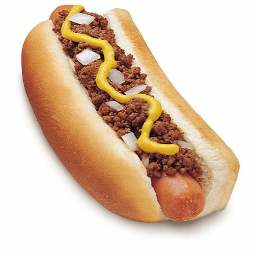

In [65]:
# convert above numpy arrays into the image using Pillow library

from PIL import Image
Image.fromarray(first_image.numpy().astype('uint8'))   # Pillow converts numpy matrices into the image itslef 


In [31]:
train = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)   # Caches pictures in memory rather than hard disk to make algorithm more efficient
test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)   # Caches pictures in memory rather than hard disk to make algorithm more efficient


In [ ]:
# Account for overfitting and increas emodel accuracy
# paste model from before into function so as to not have to change the code every time

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

def train_model(network,epochs=5):
    model = Sequential(network)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics =['accuracy'])
    history = model.fit(
    train,
    validation_data=test,
    epochs=5,
    verbose=1
)
    history_df = pd.DataFrame.from_dict(history.history)
    return history_df,model

In [36]:
# same netwrok as before, modified with new layers


network = [
    layers.Rescaling(1./255),    
    layers.Conv2D(16,4,padding='same',activation='relu',input_shape=(256,256,3)),     # increase window size to 4 from 3
    layers.MaxPooling2D(),                                                            # add max pooling 2d layer to reduce overfit and reduce number of parameters
    layers.Conv2D(32,4,padding='same',activation='relu',input_shape=(256,256,3)),     # add second convolutional layer with increased filters to 32, to let network pick up higher level features
    layers.MaxPooling2D(),                                                           # add another max pooling layer
    layers.Conv2D(64,4,padding='same',activation='relu',input_shape=(256,256,3)),    # add another convolutional layer with 64 filters for even higher level features
    layers.MaxPooling2D(),                                                           # another max pooling layer
    layers.Dropout(.2),                                                              # Dropout layer helps with overfitting by setting some outputs to 0 randomly, so network doesnt become too linked to trainjing data
    layers.Flatten(),
    layers.Dense(128,activation='relu'),  
    layers.Dense(2)             
]

# run model again

history_df,model = train_model(network)

Epoch 1/5


4/4 [==============================] - ETA: 0s - loss: 2.6167 - accuracy: 0.5098

2023-06-26 20:11:13.912017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [68]
	 [[{{node Placeholder/_4}}]]
2023-06-26 20:11:13.912262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [68]
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 3s 475ms/step - loss: 2.6167 - accuracy: 0.5098 - val_loss: 2.2771 - val_accuracy: 0.5735
Epoch 2/5
4/4 [==============================] - 2s 427ms/step - loss: 1.2064 - accuracy: 0.6275 - val_loss: 0.7118 - val_accuracy: 0.4265
Epoch 3/5
4/4 [==============================] - 2s 429ms/step - loss: 0.6938 - accuracy: 0.5294 - val_loss: 0.6219 - val_accuracy: 0.7941
Epoch 4/5
4/4 [==============================] - 2s 430ms/step - loss: 0.5399 - accuracy: 0.7353 - val_loss: 0.4510 - val_accuracy: 0.7647
Epoch 5/5
4/4 [==============================] - 2s 438ms/step - loss: 0.4177 - accuracy: 0.8039 - val_loss: 0.4227 - val_accuracy: 0.7794


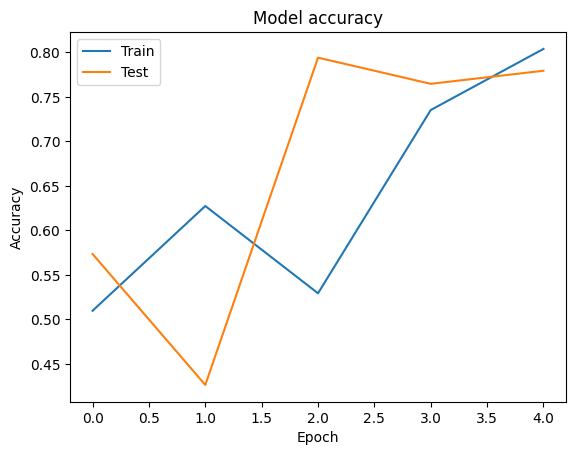

In [37]:
# Plot model accuracy

plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();


In [38]:
# Data augmentaion may help with overfitting with keras layers, set to a sequential layer
# set seeds for reproducibility 

data_augmentaion = tf.keras.Sequential([
    layers.RandomFlip('horizontal',seed=1),         # Randomly flips images from left to right which the model wuill see as a new image and increase accuracy
    layers.RandomRotation(.2,seed=1),               # Randomly raotates images for more information
    layers.RandomZoom(.2,seed=1)                   #randomly zooms images for more information for the model 
])

In [39]:
# add netwroks together to create full network

full_network = [data_augmentaion] + network

In [40]:
# Train the full network

history_df, model = train_model(full_network)

Epoch 1/5
4/4 [==============================] - 3s 494ms/step - loss: 2.4940 - accuracy: 0.4608 - val_loss: 0.6487 - val_accuracy: 0.8088
Epoch 2/5
4/4 [==============================] - 2s 457ms/step - loss: 0.6774 - accuracy: 0.6176 - val_loss: 0.6618 - val_accuracy: 0.6029
Epoch 3/5
4/4 [==============================] - 2s 469ms/step - loss: 0.6679 - accuracy: 0.6373 - val_loss: 0.6280 - val_accuracy: 0.5735
Epoch 4/5
4/4 [==============================] - 2s 470ms/step - loss: 0.6315 - accuracy: 0.6373 - val_loss: 0.5779 - val_accuracy: 0.7059
Epoch 5/5
4/4 [==============================] - 2s 468ms/step - loss: 0.5847 - accuracy: 0.6667 - val_loss: 0.5447 - val_accuracy: 0.8529


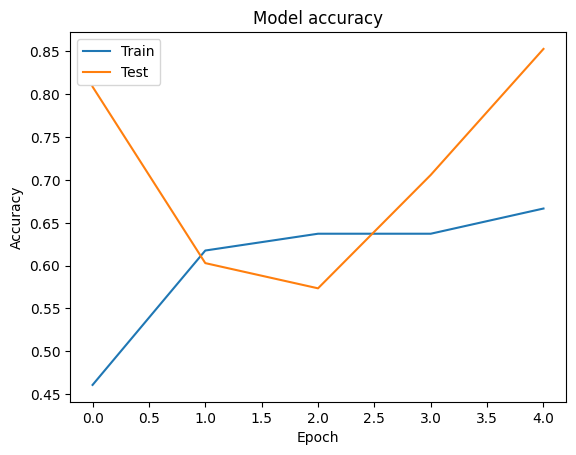

In [41]:
# Plot training & validation accuracy values

plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();


In [42]:
# Pull predictions out and visulaize them 

preds = model.predict(test)    # large numpy array; convert to pandas dataframe to make it easier to work with


3/3 [==============================] - 0s 41ms/step


In [48]:
import numpy as np 

predicted_class = np.argmax(preds,axis=1)    # turns predictions into a single number


In [49]:
actual_labels = np.concatenate([y for x,y in test],axis=0)   # flattens out batches and pulls out labels

In [50]:
actual_labels   # they are vectors so change them to single numbers
actual_class = np.argmax(actual_labels,axis=1)

In [51]:
# Get actual images of the food

import itertools

actual_image = [x.numpy().astype('uint8') for x,y in test]
actual_image = list(itertools.chain.from_iterable(actual_image))
actual_image = [Image.fromarray(a) for a in actual_image]

In [52]:
# create datframe from predicted, actual, and the images of the food

pred_df = pd.DataFrame(zip(predicted_class,actual_class,actual_image),columns=['prediction','actual','image'])


In [53]:
# change classes from numbers to the actual names

pred_df['prediction'] = pred_df['prediction'].apply(lambda x : foods[x])
pred_df['actual'] = pred_df['actual'].apply(lambda x : foods[x])


In [54]:
# Render actual images instead of image data

import base64
import io
def image(img):
    with io.BytesIO() as buffer:
        img.save(buffer,'png')
        img_str = base64.b64encode(buffer.getvalue()).decode()
        return f'<img src="data:image/jpeg;base64,{img_str}">'
      

,prediction,actual,image
0,hotdogs,hotdogs,
1,hotdogs,not_hotdogs,
2,not_hotdogs,not_hotdogs,
3,not_hotdogs,not_hotdogs,
4,not_hotdogs,not_hotdogs,
5,hotdogs,hotdogs,
6,hotdogs,hotdogs,
7,hotdogs,hotdogs,
8,not_hotdogs,not_hotdogs,
9,hotdogs,hotdogs,

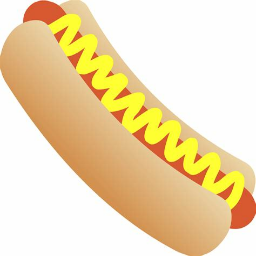
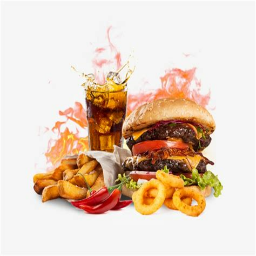
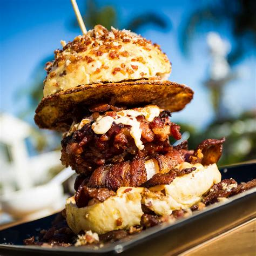
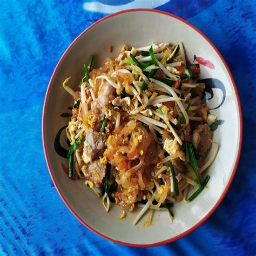
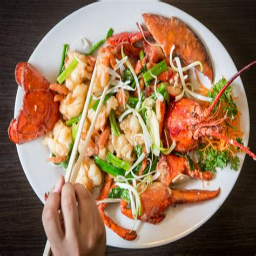
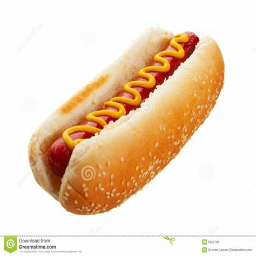
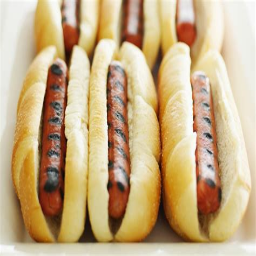
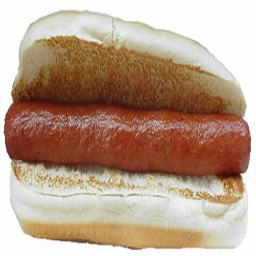
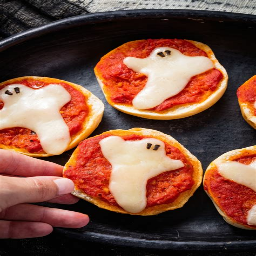
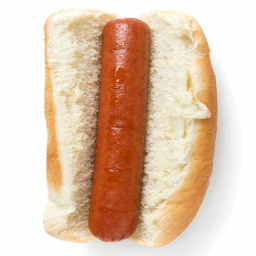

In [55]:
# Look at predictions

# Shuffle the DataFrame randomly
sample_df = pred_df.sample(frac=1).reset_index(drop=True)

# Select the first 10 rows
sample_df.head(10).style.format({'image':image})


In [56]:
# Lets try to optimize further using keras tuner

from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
 

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.experimental.preprocessing.Rescaling(1./255))  
    model.add(layers.experimental.preprocessing.RandomFlip('horizontal', seed=1))  # Randomly flip images
    model.add(layers.experimental.preprocessing.RandomRotation(0.2, seed=1))  # Randomly rotate images
    model.add(layers.experimental.preprocessing.RandomZoom(0.2, seed=1))  # Randomly zoom images
    model.add(layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                            kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
                            activation='relu',
                            input_shape=(256,256,3)))  # change input shape if necessary
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
                            kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                            activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
                           activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))  # output layer

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
stop_early = EarlyStopping(monitor='val_accuracy', patience=5)

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='project',
    project_name='Hotdog Classifier')

tuner.search_space_summary()



tuner.search(train,
             epochs=50,
             validation_data=test,
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('dense_1_units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Trial 5 Complete [00h 01m 48s]
val_accuracy: 0.8235293924808502

Best val_accuracy So Far: 0.8235293924808502
Total elapsed time: 00h 08m 05s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 112 and the optimal learning rate for the optimizer
is 0.001.



In [58]:
# First, get the optimal hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

model.compile(optimizer=keras.optimizers.Adam(best_hps.get('learning_rate')),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit the model
history = model.fit(train, 
                    epochs=50, 
                    validation_data= test,verbose=1,
                    callbacks=[stop_early])


Epoch 1/50


4/4 [==============================] - 6s 1s/step - loss: 9.5531 - accuracy: 0.5098 - val_loss: 2.0842 - val_accuracy: 0.5735
Epoch 2/50
4/4 [==============================] - 5s 1s/step - loss: 1.0946 - accuracy: 0.6176 - val_loss: 0.6893 - val_accuracy: 0.7059
Epoch 3/50
4/4 [==============================] - 5s 1s/step - loss: 0.6673 - accuracy: 0.6373 - val_loss: 0.6624 - val_accuracy: 0.5735
Epoch 4/50
4/4 [==============================] - 5s 1s/step - loss: 0.6871 - accuracy: 0.5588 - val_loss: 0.6796 - val_accuracy: 0.6029
Epoch 5/50
4/4 [==============================] - 5s 1s/step - loss: 0.6715 - accuracy: 0.6275 - val_loss: 0.6610 - val_accuracy: 0.5735
Epoch 6/50
4/4 [==============================] - 5s 1s/step - loss: 0.6344 - accuracy: 0.6275 - val_loss: 0.6568 - val_accuracy: 0.5735
Epoch 7/50
4/4 [==============================] - 5s 1s/step - loss: 0.6553 - accuracy: 0.6569 - val_loss: 0.6465 - val_accuracy: 0.5735


In [59]:
# Evaluate the model on the test data
score = model.evaluate(test,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.6464685201644897
Test accuracy: 0.5735294222831726


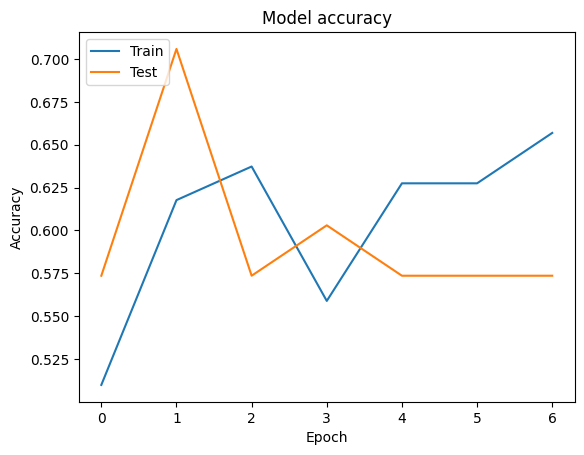

In [60]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


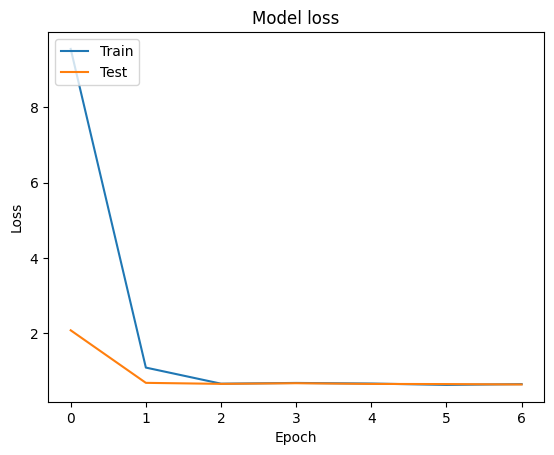

In [61]:
# Plot training & validation loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()